In [1]:
import numpy as np
import pandas as pd

frame = pd.read_excel("data_gdm_discrete_BMI_merged.xlsx", engine="openpyxl")
frame.oDM = (frame.oDM == 2).astype(int)
for name in frame.columns:
    frame[name] = frame[name].astype('category')

print (frame)
print (frame.oDM.value_counts())

     AgeCat BMICat Race Education GravCat SmokeCat1 SmokeCat2 oDM
0         3      0    1         3       2         1         1   0
1         1      2    2         2       1         1         2   0
2         0      0    2         1       1         2         2   0
3         2      2    3         3       2         2         2   0
4         1      0    3         4       1         2         2   0
...     ...    ...  ...       ...     ...       ...       ...  ..
9215      2      1    1         4       2         1         1   0
9216      1      0    3         3       2         2         2   0
9217      0      0    3         1       2         2         2   0
9218      2      1    1         2       3         1         1   0
9219      3      2    1         5       1         1         1   0

[9220 rows x 8 columns]
0    8832
1     388
Name: oDM, dtype: int64


In [2]:
from imblearn.under_sampling import InstanceHardnessThreshold
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': [2, 3, 4], 'n_estimators': list(range(20, 101, 20))}
est = GridSearchCV(XGBClassifier(eval_metric='logloss', use_label_encoder=False), param_grid=param_grid)
X = frame.drop('oDM', axis=1)
y = frame.oDM
est.fit(X.to_numpy(), y)
ros = InstanceHardnessThreshold(estimator=est.best_estimator_)
X_res, y_res = ros.fit_resample(X, y)
X_res['oDM'] = y_res
frame = X_res
print (frame)
print (frame.oDM.value_counts())

    AgeCat BMICat Race Education GravCat SmokeCat1 SmokeCat2 oDM
0        0      0    2         1       1         2         2   0
1        0      0    2         2       1         2         2   0
2        0      0    1         2       1         1         1   0
3        0      0    2         1       1         2         2   0
4        0      0    2         2       1         2         2   0
..     ...    ...  ...       ...     ...       ...       ...  ..
772      1      1    1         4       1         2         2   1
773      3      2    1         3       2         1         2   1
774      2      2    1         5       1         1         2   1
775      4      2    1         3       1         1         2   1
776      2      2    3         4       1         2         2   1

[777 rows x 8 columns]
0    389
1    388
Name: oDM, dtype: int64


In [3]:
frame.Race.value_counts()

1    369
2    240
3     83
5     41
8     36
7      5
6      3
4      0
Name: Race, dtype: int64

In [4]:
from sklearn.model_selection import StratifiedKFold
from spn.algorithms.LearningWrappers import learn_parametric
from spn.structure.leaves.parametric.Parametric import Categorical, Gaussian
from spn.structure.Base import Context
import warnings 

train_data = frame.to_numpy()
names = frame.columns.tolist()
categories = ['Race', 'oDM']
ptypes = [Categorical if n in categories else Gaussian for n in names]
categorical = [n in categories for n in names]

In [5]:
from spn.algorithms.Inference import log_likelihood

for n in [5, 10, 15, 20, 25]:
    splitter = StratifiedKFold()
    ll = []
    for train_i, test_i in splitter.split(train_data, train_data[:, -1]):
        train = train_data[train_i]
        test = train_data[test_i]
        
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            context = Context(parametric_types = ptypes).add_domains(train)
            net = learn_parametric(train,
                                   ds_context = context,
                                   min_instances_slice = n)
            l = log_likelihood(net, test)
            ll.append(-np.sum(l))

    print ("%6d %8.4f ± %8.4f" % (n, np.mean(ll), np.std(ll)))

     5 -6274.2013 ± 275.7349
    10 -5615.4251 ± 453.4963
    15 -4950.9307 ± 278.4839
    20 -4641.5330 ± 381.8158
    25 -4422.4583 ± 187.6887


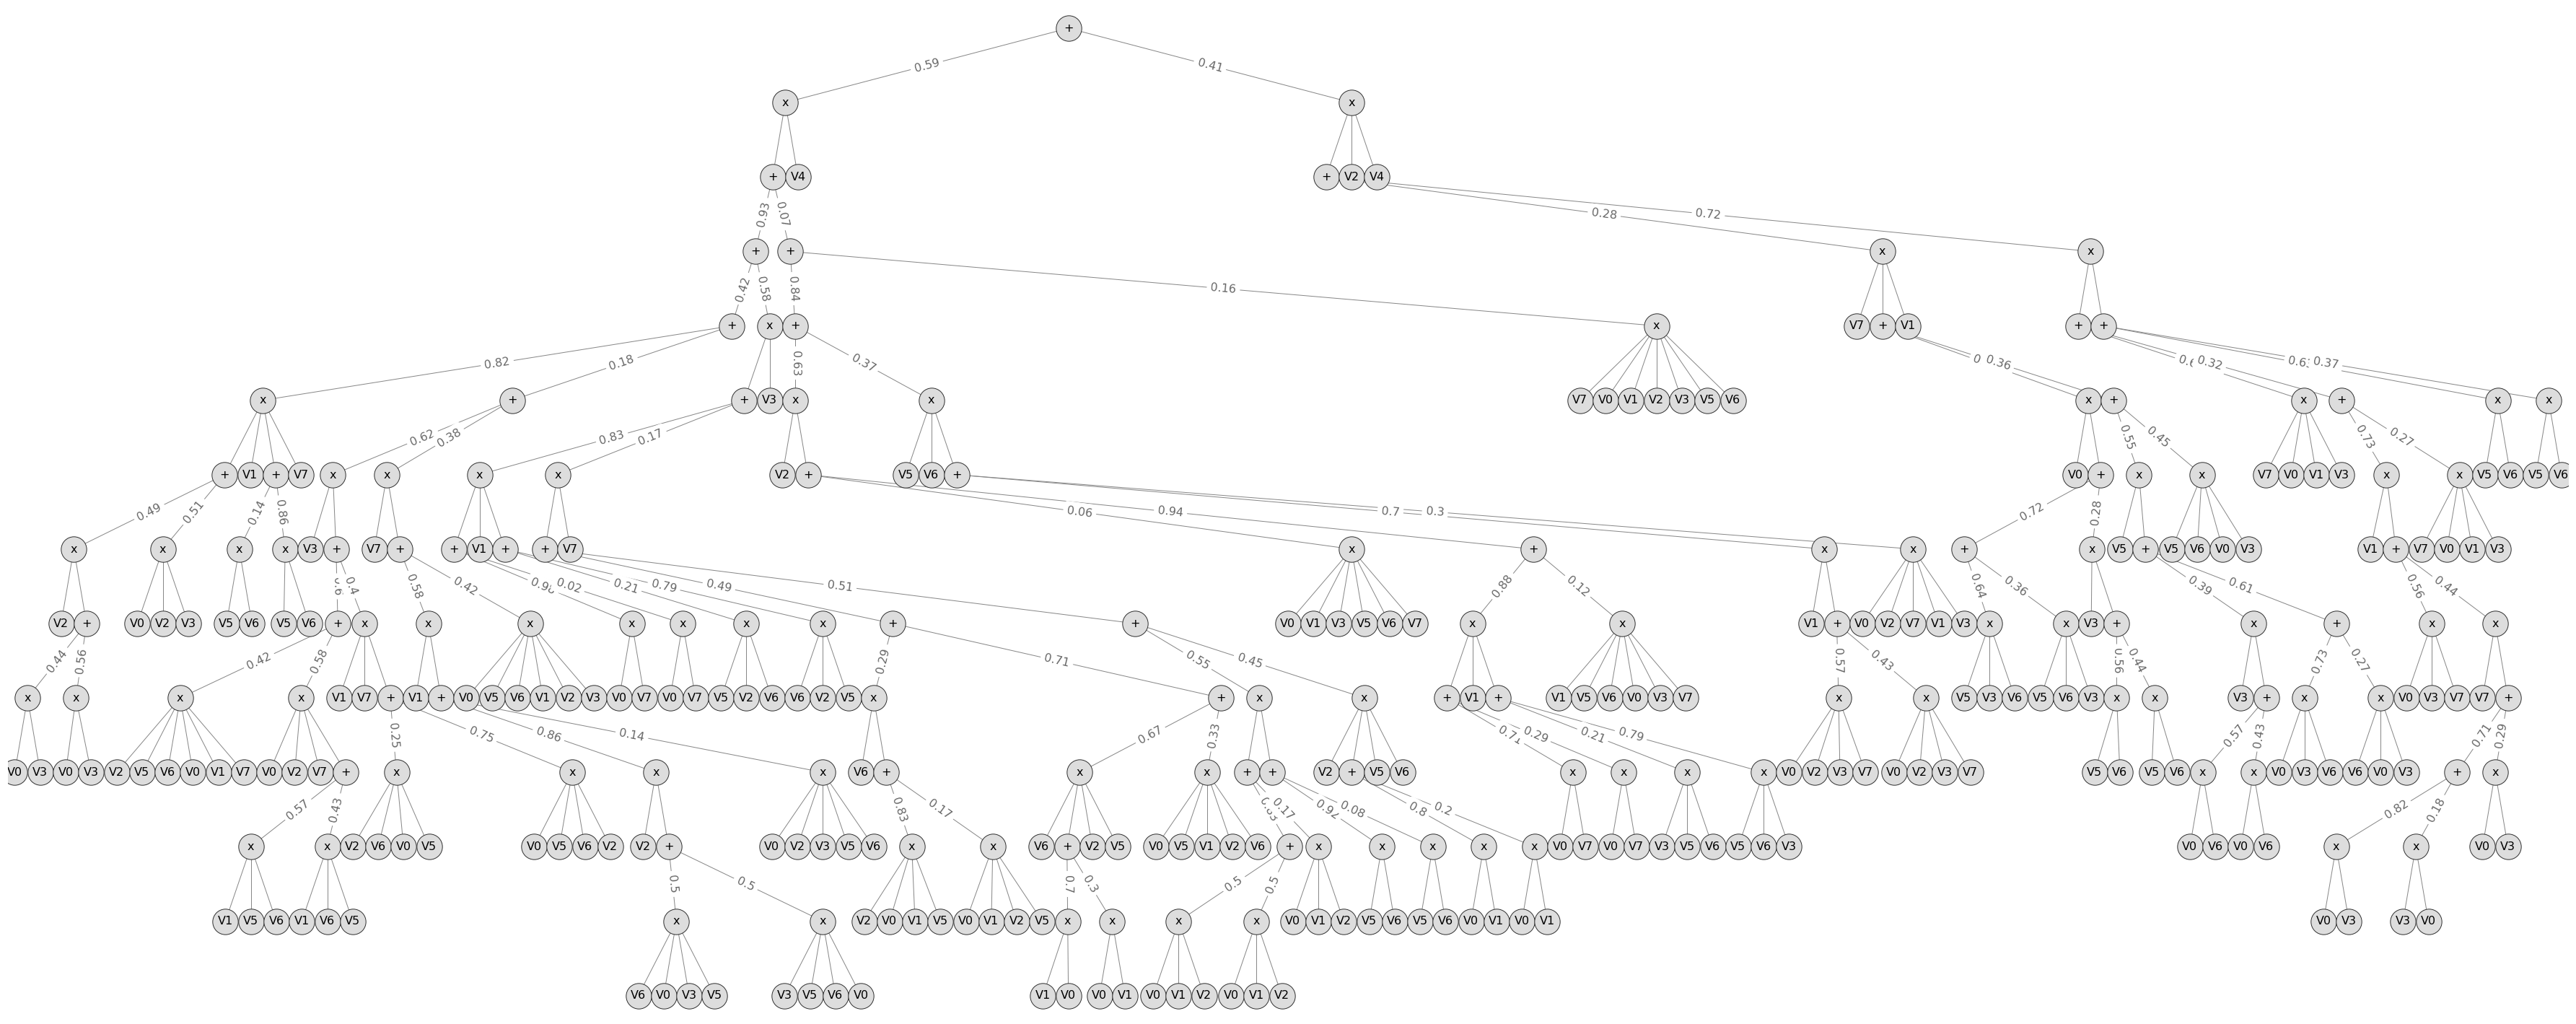

In [6]:
from spn.io.Graphics import plot_spn
import matplotlib.pyplot as plt
%matplotlib inline

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    context =  Context(parametric_types=ptypes).add_domains(train_data)
    net = learn_parametric(train_data, 
                           ds_context = context, 
                           min_instances_slice = 5)

plt.figure(figsize=(50, 20))
plot_spn(net)

In [12]:
from csi import annotate, context_specific_independences

annotate(net, names, categorical, min_impurity_decrease=0.1, min_instances_slice = 5)
for rule in context_specific_independences(net):
    print (rule)

([['AgeCat <= 1.5']], [['AgeCat', 'BMICat', 'Race', 'Education', 'SmokeCat1', 'SmokeCat2', 'oDM'], ['GravCat']], 0.9562363238512035)
([['AgeCat > 1.5']], [['AgeCat', 'BMICat', 'Education', 'SmokeCat1', 'SmokeCat2', 'oDM'], ['Race'], ['GravCat']], 0.890625)
([['AgeCat > 1.5'], ['Education <= 4.5']], [['oDM'], ['AgeCat', 'Education', 'SmokeCat1', 'SmokeCat2'], ['BMICat']], 0.890625)
([['AgeCat > 1.5'], ['Education > 4.5']], [['AgeCat', 'BMICat', 'Education', 'oDM'], ['SmokeCat1', 'SmokeCat2']], 0.875068231441048)
([['AgeCat <= 1.5'], ['Race != 8'], ['Education <= 2.5']], [['AgeCat', 'BMICat', 'Race', 'SmokeCat1', 'SmokeCat2', 'oDM'], ['Education']], 0.9562363238512035)
([['AgeCat <= 1.5'], ['Race != 8'], ['Education > 2.5'], ['oDM == 0']], [['AgeCat', 'Race', 'Education'], ['BMICat'], ['SmokeCat1', 'SmokeCat2'], ['oDM']], 0.9056135442698281)
([['AgeCat <= 1.5'], ['Race == 8'], ['Race == 8'], ['Education > 2.5']], [['Race'], ['AgeCat', 'BMICat', 'Education', 'SmokeCat1', 'SmokeCat2', 'oDM

In [11]:
frame.BMICat.value_counts()

0    464
2    182
1    131
Name: BMICat, dtype: int64

In [8]:
from csi import annotate, context_specific_independences

annotate(net, names, categorical, min_impurity_decrease=0.1)
for rule in context_specific_independences(net):
    print (rule)

([['AgeCat > 0.5']], [['AgeCat', 'BMICat', 'Education', 'SmokeCat1', 'SmokeCat2', 'oDM'], ['Race'], ['GravCat']], 1.0)
([['AgeCat <= 0.5']], [['AgeCat', 'BMICat', 'Race', 'SmokeCat1', 'SmokeCat2', 'oDM'], ['Education'], ['GravCat']], 0.8288888888888889)
([['AgeCat > 0.5'], ['Education <= 4.5']], [['oDM'], ['AgeCat', 'Education', 'SmokeCat1', 'SmokeCat2'], ['BMICat']], 1.0)
([['AgeCat > 0.5'], ['Education > 4.5']], [['AgeCat', 'BMICat', 'Education', 'oDM'], ['SmokeCat1', 'SmokeCat2']], 0.9827586206896551)
([['AgeCat <= 0.5'], ['Race != 8 and Race != 5'], ['oDM == 0']], [['AgeCat'], ['BMICat'], ['Race'], ['SmokeCat1', 'SmokeCat2'], ['oDM']], 0.8050702426564496)
([['AgeCat > 0.5'], ['Education <= 4.5'], ['AgeCat > 2.5']], [['AgeCat'], ['Education', 'SmokeCat1', 'SmokeCat2']], 1.0)
([['AgeCat > 0.5'], ['Education > 4.5'], ['AgeCat > 2.5']], [['oDM'], ['AgeCat'], ['BMICat'], ['Education']], 0.9580351333767079)
([['AgeCat > 0.5'], ['Education > 4.5'], ['SmokeCat1 > 1.5']], [['SmokeCat1'], ['